<a href="https://colab.research.google.com/github/rondinell/Intelig-ncia-Artificial/blob/main/Artigo2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
!pip install alpha_vantage

In [84]:
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt

In [64]:
# Configurar sua chave de API
chave_api = 'JFZ0ASX1UYOK101E'  # Substitua pela sua chave

In [65]:
# Inicializar o objeto TimeSeries
ts = TimeSeries(key='JFZ0ASX1UYOK101E', output_format='pandas')  # Saída como DataFrame

In [66]:
# Buscar dados diários da PETR4 (B3)
dados, meta_dados = ts.get_daily(symbol='PETR4.SA', outputsize='compact')

In [85]:
# Mostrar os últimos 5 registros
print(dados.tail())

            Preço      RSI
date                      
2025-04-30  29.99  31.1814
2025-05-02  30.81  39.6124
2025-05-05  29.66  33.4274
2025-05-06  30.15  37.8781
2025-05-07  30.29  39.1303


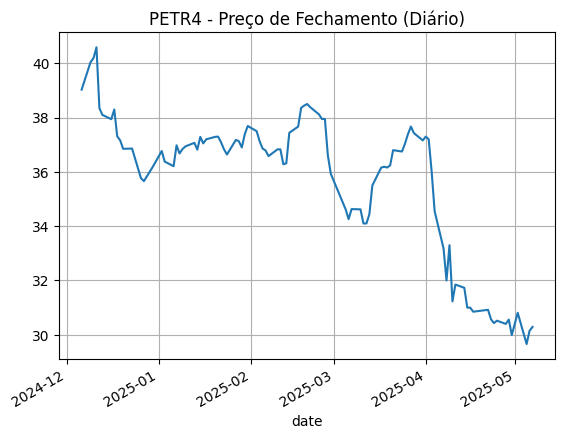

In [68]:
# Plotar preço de fechamento
dados['4. close'].plot(title='PETR4 - Preço de Fechamento (Diário)')
plt.grid()
plt.show()

In [69]:
from alpha_vantage.techindicators import TechIndicators
# 1. Initialize the TechIndicators object
ti = TechIndicators(key='JFZ0ASX1UYOK101E', output_format='pandas')  # Replace YOUR_API_KEY

In [70]:

# Obter RSI (14 dias)
rsi_dados, rsi_meta = ti.get_rsi(symbol='PETR4.SA', interval='daily', time_period=14)

In [71]:
# 1. Buscar dados do RSI
ti = TechIndicators(key=chave_api, output_format='pandas')
ticker = 'PETR4.SA'  # Define o ticker aqui
rsi_dados, _ = ti.get_rsi(symbol=ticker, interval='daily', time_period=14)

# 2. Buscar dados de preço (fechamento)
ts = TimeSeries(key=chave_api, output_format='pandas')
dados_preco, _ = ts.get_daily(symbol=ticker, outputsize='compact')



In [72]:
import pandas as pd
# 3. Juntar RSI e Preço no mesmo DataFrame
dados = pd.DataFrame({
    'Preço': dados_preco['4. close'],
    'RSI': rsi_dados['RSI']
}).dropna()  # Remove linhas com valores faltantes


--- Preços nos Cruzamentos do RSI ---

Sobrevendido (RSI >= 30):
date
2025-03-07    34.63
2025-03-13    34.44
2025-04-09    33.30
2025-04-11    31.85
2025-04-17    30.85
Name: Preço, dtype: float64

Sobrecomprado (RSI <= 70):
date
2024-12-12    38.34
Name: Preço, dtype: float64


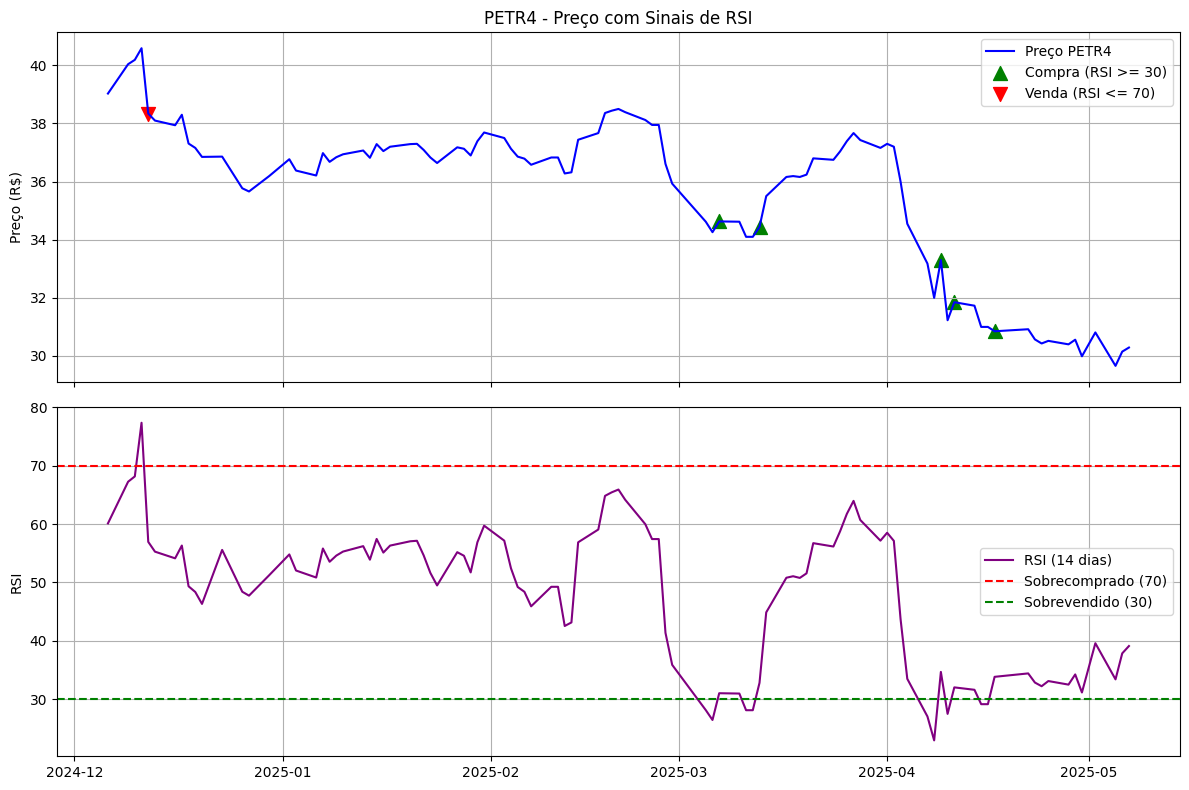

In [73]:
# 4. Identificar cruzamentos
cruzamentos_sobrevendido = (dados['RSI'].shift(1) < 30) & (dados['RSI'] >= 30)
cruzamentos_sobrecomprado = (dados['RSI'].shift(1) > 70) & (dados['RSI'] <= 70)

# 5. Extrair preços nos cruzamentos
precos_sobrevendido = dados[cruzamentos_sobrevendido]['Preço']
precos_sobrecomprado = dados[cruzamentos_sobrecomprado]['Preço']

print("--- Preços nos Cruzamentos do RSI ---")
print("\nSobrevendido (RSI >= 30):")
print(precos_sobrevendido)
print("\nSobrecomprado (RSI <= 70):")
print(precos_sobrecomprado)

# 6. Plotar gráfico com preços e RSI
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Gráfico do Preço
ax1.plot(dados['Preço'], label='Preço PETR4', color='blue')
ax1.scatter(precos_sobrevendido.index, precos_sobrevendido, color='green', label='Compra (RSI >= 30)', marker='^', s=100)
ax1.scatter(precos_sobrecomprado.index, precos_sobrecomprado, color='red', label='Venda (RSI <= 70)', marker='v', s=100)
ax1.set_title('PETR4 - Preço com Sinais de RSI')
ax1.set_ylabel('Preço (R$)')
ax1.legend()
ax1.grid(True)

# Gráfico do RSI
ax2.plot(dados['RSI'], label='RSI (14 dias)', color='purple')
ax2.axhline(70, color='red', linestyle='--', label='Sobrecomprado (70)')
ax2.axhline(30, color='green', linestyle='--', label='Sobrevendido (30)')
ax2.set_ylabel('RSI')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [74]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


In [75]:

# Usaremos apenas a coluna de preço para a previsão
data = dados['Preço'].values.reshape(-1, 1)

# Normalização dos dados (LSTMs são sensíveis à escala)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Criar conjuntos de treinamento
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Função para criar sequências temporais
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length-1):
        X.append(data[i:(i+seq_length), 0])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 14  # Usaremos 14 dias para prever o próximo
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)
# Reshape para formato [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [76]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Saída para prever o preço

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [77]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    verbose=1)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 522ms/step - loss: 0.3501 - val_loss: 0.0024
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1649 - val_loss: 0.0232
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0357 - val_loss: 0.0874
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0417 - val_loss: 0.0954
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0429 - val_loss: 0.0592
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0198 - val_loss: 0.0408
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0230 - val_loss: 0.0432
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0270 - val_loss: 0.0555
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0180 - val_loss: 0.0670
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0175 - val_loss: 0.0816
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0188 - val_loss: 0.0833
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0135 - val_loss: 0.0684


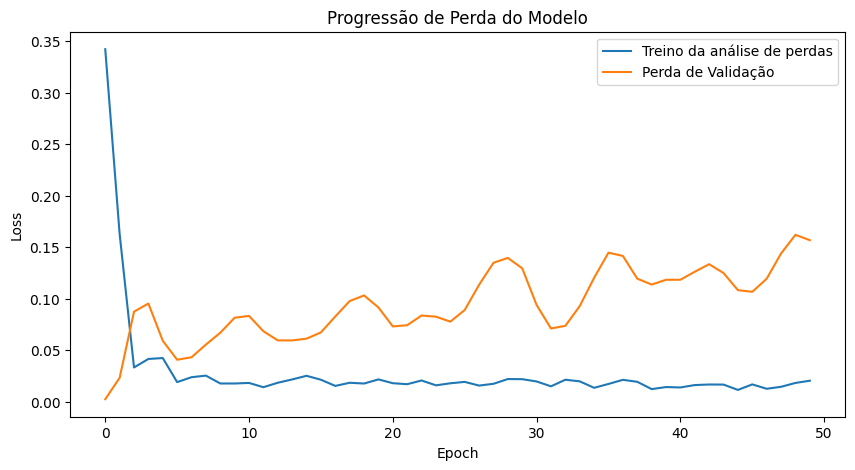

In [86]:
# Plotar a perda durante o treinamento
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Treino da análise de perdas')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Progressão de Perda do Modelo')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [79]:
# Usar os últimos 14 dias conhecidos para iniciar a previsão
last_sequence = scaled_data[-seq_length:]
future_predictions = []
current_sequence = last_sequence.reshape((1, seq_length, 1))

for i in range(14):  # Prever os próximos 14 dias
    next_pred = model.predict(current_sequence)
    future_predictions.append(next_pred[0,0])
    # Atualizar a sequência com a nova previsão
    current_sequence = np.append(current_sequence, [[[next_pred[0,0]]]], axis=1)
    current_sequence = current_sequence[:, 1:, :]


# Desnormalizar as previsões
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Criar datas futuras
last_date = dados.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=14)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


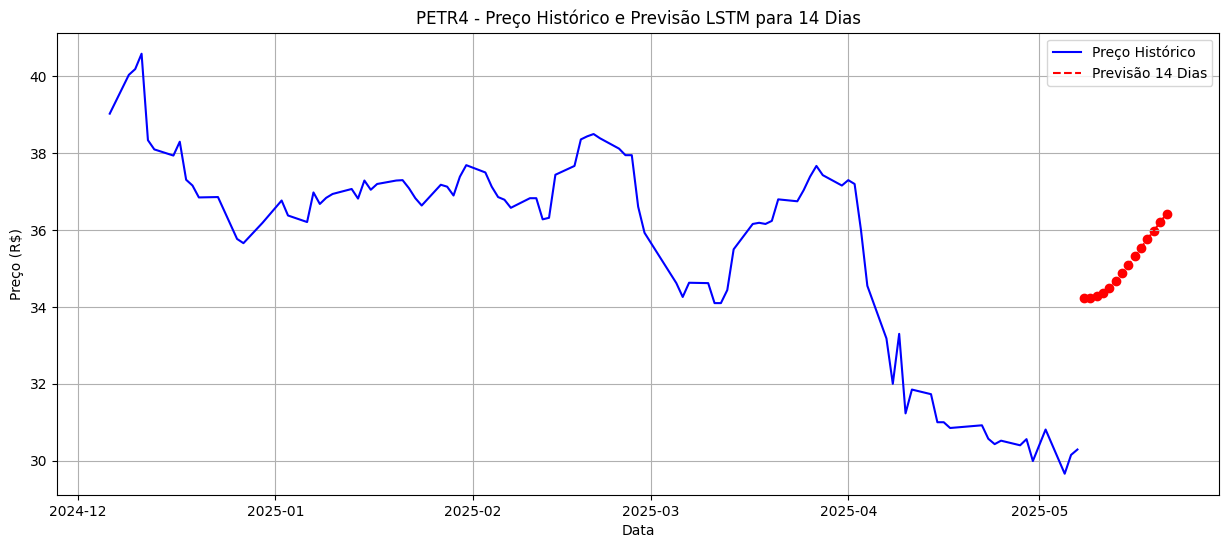


Previsões para os próximos 14 dias:
2025-05-08: R$ 34.24
2025-05-09: R$ 34.23
2025-05-10: R$ 34.27
2025-05-11: R$ 34.37
2025-05-12: R$ 34.50
2025-05-13: R$ 34.68
2025-05-14: R$ 34.88
2025-05-15: R$ 35.10
2025-05-16: R$ 35.32
2025-05-17: R$ 35.54
2025-05-18: R$ 35.78
2025-05-19: R$ 35.98
2025-05-20: R$ 36.21
2025-05-21: R$ 36.42


In [80]:
plt.figure(figsize=(15, 6))
plt.plot(dados.index, dados['Preço'], label='Preço Histórico', color='blue')
plt.plot(future_dates, future_predictions, label='Previsão 14 Dias', color='red', linestyle='--')
plt.scatter(future_dates, future_predictions, color='red')
plt.title('PETR4 - Preço Histórico e Previsão LSTM para 14 Dias')
plt.xlabel('Data')
plt.ylabel('Preço (R$)')
plt.legend()
plt.grid(True)
plt.show()

print("\nPrevisões para os próximos 14 dias:")
for date, price in zip(future_dates, future_predictions):
    print(f"{date.strftime('%Y-%m-%d')}: R$ {price[0]:.2f}")